In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 95% !important; }</style>"))

In [2]:
from pysb import *
from pysb.export import export
from pysb.bng import generate_network, generate_equations
from pysb.pathfinder import set_path
from pysb.simulator import ScipyOdeSimulator, BngSimulator
from pylab import linspace, plot, xlabel, ylabel, show

import seaborn
import matplotlib.pyplot as plt

palette = seaborn.color_palette('colorblind')

set_path('bng', '/opt/git-repositories/bionetgen.RuleWorld/bng2/')

In [3]:
import os
import re
import numpy
import pandas

In [4]:
Model()

<Model '_interactive_' (monomers: 0, rules: 0, parameters: 0, expressions: 0, compartments: 0) at 0x7fe7f6454eb8>

In [20]:
with open('../lactose/networks/metabolism_v2.txt', 'r') as infile:
    data = pandas.read_csv(infile, delimiter = '\t', header = None, comment = '#')
# data

In [6]:
def monomers_from_metabolic_network(data, verbose = False):    
    tmp = list(data.iloc[:, 2].values) + list(data.iloc[:, 3].values)
    tmp = [ ' '.join(x.replace('PER-', '').split(', ')) for x in tmp]
    tmp = ' '.join(tmp).split(' ')
    # print(tmp)

    metabolites = list(set(tmp)) # unique elements
    for index, met in enumerate(metabolites):
        if met[0].isdigit():
            metabolites[index] = '_' + met

    code = "Monomer('met',\n        ['name', 'loc', 'prot'],\n" \
          "        { 'name' :\n            [ " + \
          ', '.join([ '\'' + x.replace('-', '_') + '\'' for x in sorted(metabolites)]) + " ], \n" \
          "          'loc' : ['cyt', 'per', 'ex']})"

    if verbose:
        print(code)
    code = code.replace('\n', '')
    exec(code)
    
    tmp = list(data.iloc[:, 0].values)
    tmp = [ ' '.join(x.replace('PER-', '').split(', ')) for x in tmp]
    tmp = ' '.join(tmp).split(' ')

    complexes = []
    p_monomers = []
    proteins = list(set(tmp)) # unique elements
    for index, protein in enumerate(proteins):
        if protein[0].isdigit():
            protein[index] = '_' + protein
        if 'CPLX' in protein:
            complexes.append(protein)
        else:
            if 'spontaneous' != protein:
                p_monomers.append(protein)

    code = "Monomer('prot',\n        ['name', 'loc', 'prot'],\n" \
          "        { 'name' :\n            [ " + \
          ', '.join([ '\'' + x.replace('-', '_') + '\'' for x in sorted(p_monomers)]) + " ], \n" \
          "          'loc' : ['cyt', 'mem', 'per', 'ex']})"

    if verbose:
        print(code)
    code = code.replace('\n', '')
    exec(code)

    code = "Monomer('cplx',\n        ['name', 'loc', 'prot'],\n" \
          "        { 'name' :\n            [ " + \
          ', '.join([ '\'' + x.replace('-', '_') + '\'' for x in sorted(complexes)]) + " ], \n" \
          "          'loc' : ['cyt', 'mem', 'per', 'ex']})"

    if verbose:
        print(code)
    code = code.replace('\n', '')
    exec(code)
    
    return metabolites, p_monomers, complexes

In [7]:
metabolites, p_monomers, complexes = monomers_from_metabolic_network(data, verbose = True)

Monomer('met',
        ['name', 'loc', 'prot'],
        { 'name' :
            [ 'ACETYL_COA', 'CO_A', 'CPD_3561', 'CPD_3785', 'CPD_3801', 'D_ARABINOSE', 'Fructofuranose', 'MELIBIOSE', 'PROTON', 'WATER', '_6_Acetyl_beta_D_Galactose', 'alpha_ALLOLACTOSE', 'alpha_GALACTOSE', 'alpha_glucose', 'alpha_lactose', 'beta_ALLOLACTOSE', 'beta_GALACTOSE', 'beta_glucose', 'beta_lactose' ], 
          'loc' : ['cyt', 'per', 'ex']})
Monomer('prot',
        ['name', 'loc', 'prot'],
        { 'name' :
            [ 'LACY_MONOMER' ], 
          'loc' : ['cyt', 'mem', 'per', 'ex']})
Monomer('cplx',
        ['name', 'loc', 'prot'],
        { 'name' :
            [ 'BETAGALACTOSID_CPLX', 'GALACTOACETYLTRAN_CPLX' ], 
          'loc' : ['cyt', 'mem', 'per', 'ex']})


In [8]:
def model_from_metabolism(data, verbose = False):
    for rxn in data.values:
        # first, determine enzyme composition
        if 'CPLX' in rxn[0]: # the enzyme is a complex alias
            enzyme = 'cplx(name = \'{:s}\', loc = \'cyt\')'.format(rxn[0].replace('-', '_'))

        elif rxn[0].startswith('['): # an enzymatic complex described by its monomers
            monomers = rxn[0][1:-1].split(', ')
            enzyme = []

            ## create link indexes
            dw = [None] * len(monomers)
            start_link = 1
            for index in range(len(monomers)-1):
                dw[index] = start_link
                start_link += 1
            up = dw[-1:] + dw[:-1]

            for index, monomer in enumerate(monomers):
                enzyme.append('prot(name = \'{:s}\', loc = \'cyt\', up = {:s}, dw = {:s})'.format(monomer, str(up[index]), str(dw[index])))
            enzyme = ' %\n    '.join(enzyme)

        else: # the enzyme is a monomer
            enzyme = 'prot(name = \'{:s}\', loc = \'cyt\')'.format(rxn[0].replace('-', '_'))

        # second, correct reaction names starting with a digit
        name = rxn[1].replace('-', '_')
        if name[0].isdigit():
            name = '_' + name
            
        # third, correct metabolite names with dashes and create a list
        substrates = rxn[2].replace('-', '_').split(', ')
        products = rxn[3].replace('-', '_').split(', ')

        # fourth, write LHS and RHS
        LHS = []
        RHS = []

        for subs in substrates:
            if subs[0].isdigit():
                subs = '_' + subs

            if 'PER' in subs:
                LHS.append('met(name = \'{:s}\', loc = \'per\', prot = None)'.format(subs.replace('PER_', '')))
            else:
                LHS.append('met(name = \'{:s}\', loc = \'cyt\', prot = None)'.format(subs))

        for prod in products:
            if prod[0].isdigit():
                prod = '_' + prod

            if 'PER' in prod: # inverse transport reaction
                RHS.append('met(name = \'{:s}\', loc = \'per\', prot = None)'.format(prod.replace('PER_', '')))
            else:
                RHS.append('met(name = \'{:s}\', loc = \'cyt\', prot = None)'.format(prod))

        # fifth, match number of agents at both sides of the Rule
        if len(substrates) < len(products):
            for index in range(len(substrates), len(products)):
                LHS.append('None')
        elif len(products) < len(substrates):
            for index in range(len(products), len(substrates)):
                RHS.append('None')

        # pretty print Rule
        LHS = ' +\n    '.join(LHS)
        RHS = ' +\n    '.join(RHS)

        if rxn[0] == 'spontaneous':
            code = 'Rule(\'{:s}\',\n' \
                   '    {:s} |\n'\
                   '    {:s}, \n' \
                   '    Parameter(\'fwd_{:s}\', {:f}), \n' \
                   '    Parameter(\'rvs_{:s}\', {:f}))' \
                   .format(name, LHS, RHS, name, float(rxn[4]), name, float(rxn[5]))

        else: # need an enzyme
            code = 'Rule(\'{:s}\',\n' \
                   '    {:s} +\n    {:s} | \n' \
                   '    {:s} +\n    {:s}, \n' \
                   '    Parameter(\'fwd_{:s}\', {:f}), \n' \
                   '    Parameter(\'rvs_{:s}\', {:f}))' \
                   .format(name, enzyme, LHS, enzyme, RHS, name, float(rxn[4]), name, float(rxn[5])).replace('-', '_')

        if verbose:
            print(code)
            
        # finally, execute code
        code = code.replace('\n', '')
        try:
            exec(code)
        except:
            continue

    #     with open('reactions.py', 'a+') as outfile:
    #         outfile.write(Rule)
    #         outfile.write('\n\n')

In [9]:
model_from_metabolism(data, verbose = True)

Rule('LACTOSE_MUTAROTATION',
    met(name = 'alpha_lactose', loc = 'cyt', prot = None) |
    met(name = 'beta_lactose', loc = 'cyt', prot = None), 
    Parameter('fwd_LACTOSE_MUTAROTATION', 1.000000), 
    Parameter('rvs_LACTOSE_MUTAROTATION', 1.000000))
Rule('GALACTOSE_MUTAROTATION',
    met(name = 'alpha_GALACTOSE', loc = 'cyt', prot = None) |
    met(name = 'beta_GALACTOSE', loc = 'cyt', prot = None), 
    Parameter('fwd_GALACTOSE_MUTAROTATION', 1.000000), 
    Parameter('rvs_GALACTOSE_MUTAROTATION', 1.000000))
Rule('GLUCOSE_MUTAROTATION',
    met(name = 'alpha_glucose', loc = 'cyt', prot = None) |
    met(name = 'beta_glucose', loc = 'cyt', prot = None), 
    Parameter('fwd_GLUCOSE_MUTAROTATION', 1.000000), 
    Parameter('rvs_GLUCOSE_MUTAROTATION', 1.000000))
Rule('TRANS_RXN_24',
    prot(name = 'LACY_MONOMER', loc = 'cyt') +
    met(name = 'PROTON', loc = 'per', prot = None) +
    met(name = 'alpha_lactose', loc = 'per', prot = None) | 
    prot(name = 'LACY_MONOMER', loc = 'cyt'

In [10]:
def observables_from_metabolic_network():
    for name in sorted(metabolites):
        name = name.replace('-','_')
        for loc in ['cyt', 'per', 'ex']:
            code = 'Observable(\'obs_{:s}_{:s}\', met(name = \'{:s}\', loc = \'{:s}\', prot = None))'.format(name, loc, name, loc)
            code = code.replace('\t', '')
            exec(code)
    
    for name in sorted(metabolites):
        name = name.replace('-','_')
        for loc in ['cyt', 'per', 'ex']:
            code = 'Initial(met(name = \'{:s}\', loc = \'{:s}\', prot = None), Parameter(\'t0_{:s}_{:s}\', 0))'.format(name, loc, name, loc)
            code = code.replace('\t', '')
            exec(code)
            
    for name in sorted(p_monomers):
        name = name.replace('-','_')
        for loc in ['cyt', 'mem', 'per', 'ex']:
            code = 'Initial(prot(name = \'{:s}\', loc = \'{:s}\', prot = None), Parameter(\'t0_{:s}_{:s}\', 0))'.format(name, loc, name, loc)
            code = code.replace('\t', '')
            exec(code)
            
    for name in sorted(complexes):
        name = name.replace('-','_')
        for loc in ['cyt', 'mem', 'per', 'ex']:
            code = 'Initial(cplx(name = \'{:s}\', loc = \'{:s}\', prot = None), Parameter(\'t0_{:s}_{:s}\', 0))'.format(name, loc, name, loc)
            code = code.replace('\t', '')
            exec(code)

In [11]:
observables_from_metabolic_network()

In [12]:
model.monomers._elements[1].site_states['name']

['LACY_MONOMER']

In [13]:
model.observables._elements

[Observable('obs_ACETYL_COA_cyt', met(name='ACETYL_COA', loc='cyt', prot=None)),
 Observable('obs_ACETYL_COA_per', met(name='ACETYL_COA', loc='per', prot=None)),
 Observable('obs_ACETYL_COA_ex', met(name='ACETYL_COA', loc='ex', prot=None)),
 Observable('obs_CO_A_cyt', met(name='CO_A', loc='cyt', prot=None)),
 Observable('obs_CO_A_per', met(name='CO_A', loc='per', prot=None)),
 Observable('obs_CO_A_ex', met(name='CO_A', loc='ex', prot=None)),
 Observable('obs_CPD_3561_cyt', met(name='CPD_3561', loc='cyt', prot=None)),
 Observable('obs_CPD_3561_per', met(name='CPD_3561', loc='per', prot=None)),
 Observable('obs_CPD_3561_ex', met(name='CPD_3561', loc='ex', prot=None)),
 Observable('obs_CPD_3785_cyt', met(name='CPD_3785', loc='cyt', prot=None)),
 Observable('obs_CPD_3785_per', met(name='CPD_3785', loc='per', prot=None)),
 Observable('obs_CPD_3785_ex', met(name='CPD_3785', loc='ex', prot=None)),
 Observable('obs_CPD_3801_cyt', met(name='CPD_3801', loc='cyt', prot=None)),
 Observable('obs_CP

In [14]:
def set_initial(name, loc, new_value):
    for i in model.parameters._elements:
        if 't0_' + name + '_' + loc in i.name:
            i.value = new_value

In [15]:
set_initial('beta_lactose', 'per', 100)
set_initial('PROTON', 'per', 100)
set_initial('WATER', 'cyt', 100)

set_initial('BETAGALACTOSID_CPLX', 'cyt', 1)
set_initial('GALACTOACETYLTRAN_CPLX', 'cyt', 1)
set_initial('LACY_MONOMER', 'cyt', 1)

In [16]:
generate_network(model)
generate_equations(model)

In [17]:
with open('test.kappa', 'w') as outfile:
    outfile.write(export(model, 'kappa'))

In [18]:
if True:
    runs = 20
    # data1 = ScipyOdeSimulator(model, linspace(0, 100, 200)).run().dataframe
    data1 = BngSimulator(model, linspace(0, 5, 501)).run(method = 'ode').dataframe
    data2 = BngSimulator(model, linspace(0, 5, 501)).run(method = 'ssa', n_runs = runs).dataframe

    data = []
    for i in range(0,runs):
        data.append(data2.xs(i))

    avrg = 0
    for i in range(0,runs):
        avrg += data[i]
    avrg = avrg / runs

    stdv = 0
    for i in range(0,runs):
        stdv = (data[i] - avrg)**2
    stdv = (stdv / (runs-1))**0.5

    data2 = data[0]

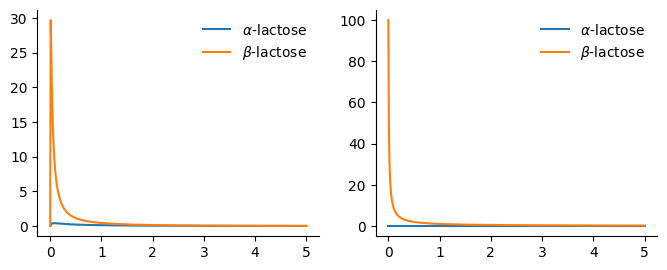

In [19]:
if True:
    fig, ax = plt.subplots(1, 2, figsize = (4*2, 3*1), dpi = 100)
    ax[0].plot(data1.index, data1['obs_alpha_lactose_cyt'], label = r'$\alpha$-lactose')
#     ax[0].scatter(data2.index, data2['obs_alpha_lactose_cyt'], label = None, s = 1)
    ax[0].plot(data1.index, data1['obs_beta_lactose_cyt'], label = r'$\beta$-lactose')
#     ax[0].scatter(data2.index, data2['obs_beta_lactose_cyt'], label = None, s = 1)

    ax[1].plot(data1.index, data1['obs_alpha_lactose_per'], label = r'$\alpha$-lactose')
#     ax[1].scatter(data2.index, data2['obs_alpha_lactose_per'], label = None, s = 1)
    ax[1].plot(data1.index, data1['obs_beta_lactose_per'], label = r'$\beta$-lactose')
#     ax[1].scatter(data2.index, data2['obs_beta_lactose_per'], label = None, s = 1)

    ax[0].legend(frameon = False)
    ax[1].legend(frameon = False)

    seaborn.despine()
    # plt.savefig('model_complete_fig0.png', format = 'png', bbox_inches = 'tight', dpi = 300)
    plt.show()